In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-03 11:35:15.092594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 11:35:15.092756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 11:35:15.250735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/car-object-detection/data/sample_submission.csv
/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv
/kaggle/input/car-object-detection/data/testing_images/vid_5_26420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31520.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31720.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_26560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_27840.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28360.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29020.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_30720.jpg
/kaggle/

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import torch
import random
from torchvision.ops import nms
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

image_size=256
batch_size=4
device='cuda' if torch.cuda.is_available() else 'cpu'
epochs=40
lr=0.0002
# File Paths
dir_path = '/kaggle/input/car-object-detection/data'
csv_file = '/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv'


In [6]:
df = pd.read_csv(csv_file)
df['label']=[1]*len(df)

print(f"Dataframe containing {len(df)} total targets for {len(df.image.unique())} Images \n")
df


Dataframe containing 559 total targets for 355 Images 



,image,xmin,ymin,xmax,ymax,label
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,1
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,1
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,1
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,1
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,1
...,...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284,1
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895,1
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652,1
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864,1


In [7]:
from sklearn.model_selection import train_test_split
train_img_ids, val_img_ids = train_test_split(df.image.unique(),test_size=0.1,random_state=32)

train_df = df[df.image.isin(train_img_ids)]
val_df = df[df.image.isin(val_img_ids)]


In [8]:
import os
import cv2
import torch
import numpy as np
import albumentations as A

# Augmentations
image_size = 224

train_augs = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

val_augs = A.Compose([
    A.Resize(image_size, image_size),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

test_augs = A.Compose([
    A.Resize(image_size, image_size)
], is_check_shapes=False)

class CarDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, df, augs=None, train=True):
        self.df = df
        self.augs = augs
        self.image_ids = image_ids
        if train:
            self.dir_path = '/kaggle/input/car-object-detection/data/training_images'
        else:
            self.dir_path = '/kaggle/input/car-object-detection/data/testing_images'
            
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.dir_path, image_id)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        bboxes = self.df[self.df.image == image_id][['xmin', 'ymin', 'xmax', 'ymax']].values
        labels = self.df[self.df.image == image_id][['label']].values
        
        if self.augs is not None:
            data = self.augs(image=image, bboxes=bboxes, class_labels=['None']*len(bboxes))
            image = data['image']
            bboxes = data['bboxes']

        image = torch.Tensor(np.transpose(image, (2, 0, 1))) / 255.0
        bboxes = torch.Tensor(bboxes).long()
        labels = torch.Tensor(labels).long().squeeze(1)
        
        target = {}
        target['boxes'] = bboxes
        target['labels'] = labels
        
        return image, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))

# Instance
trainset = CarDetectionDataset(train_img_ids, train_df, augs=train_augs)
valset = CarDetectionDataset(val_img_ids, val_df, augs=val_augs)

print(f"{len(trainset)} Training Images containing {len(train_df)} bboxes \n")


319 Training Images containing 491 bboxes 



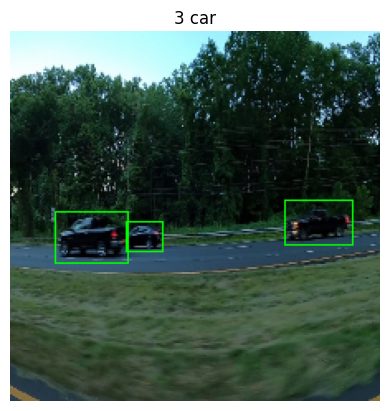

In [ ]:
idx=random.randint(0,len(trainset)-1)

image, target = trainset[idx]
bbox, label = target['boxes'], target['labels']
image = image.permute(1,2,0).numpy()

for i in range(len(bbox)):
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    c = (0,255,0)
    image = cv2.rectangle(image, sp, ep, c, 1) 

plt.imshow(image)
plt.axis('off')
plt.title(str(len(bbox))+' car')
plt.show()

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, collate_fn=trainset.collate_fn ,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, collate_fn=valset.collate_fn)

print(f"Number of Batches: {len(trainloader)}")

Number of Batches: 80


In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,2)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s] 


In [15]:
import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_ssd = torchvision.models.detection.ssd300_vgg16(preTrained=True, num_classes=2)
model_ssd.to(device);

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth
100%|██████████| 528M/528M [00:26<00:00, 21.0MB/s]  


In [21]:
from tqdm.auto import tqdm

def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0
    
    for image, target in tqdm(dataloader):
        image = list(i.to(device) for i in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        
        opt.zero_grad()
        losses = model(image, target)
        loss = sum(loss for loss in losses.values())
        loss.backward()
        opt.step()
        train_loss+=loss.item()
        
    return train_loss/len(dataloader)


In [22]:
best_train_loss=np.Inf 

opt = torch.optim.Adam(model_ssd.parameters(), lr=lr)

for i in range(epochs):
    train_loss = trainarc(model_ssd, trainloader, opt)
    
    print(f"Epoch: {i+1}:- TrainLoss: {train_loss}")
    
    if train_loss<best_train_loss:
        torch.save(model_ssd.state_dict(),'/kaggle/working/model_ssd.pt')
        print("Model Updated")
        best_train_loss=train_loss
        
print(f"DONE.\nTrainLoss: {best_train_loss}")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1:- TrainLoss: 6.164542454481125
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2:- TrainLoss: 4.576807257533074
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3:- TrainLoss: 4.059373393654823
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4:- TrainLoss: 3.88528952896595
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5:- TrainLoss: 3.751715338230133
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6:- TrainLoss: 3.6561664670705794
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7:- TrainLoss: 3.5217296183109283
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 8:- TrainLoss: 3.469182586669922
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9:- TrainLoss: 3.466674509644508
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 10:- TrainLoss: 3.4081163972616197
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 11:- TrainLoss: 3.343684473633766
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 12:- TrainLoss: 3.3344056010246277
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 13:- TrainLoss: 3.303311640024185
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 14:- TrainLoss: 3.2420179337263106
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 15:- TrainLoss: 3.246907150745392


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 16:- TrainLoss: 3.2591487362980844


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 17:- TrainLoss: 3.1606699392199515
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 18:- TrainLoss: 3.1780259400606155


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 19:- TrainLoss: 3.1771584659814835


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 20:- TrainLoss: 3.062705382704735
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 21:- TrainLoss: 3.123278281092644


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 22:- TrainLoss: 3.042867510020733
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 23:- TrainLoss: 3.0708547666668893


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 24:- TrainLoss: 3.0711510866880416


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 25:- TrainLoss: 3.045616368949413


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 26:- TrainLoss: 2.987557438015938
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 27:- TrainLoss: 3.011245313286781


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 28:- TrainLoss: 2.920523051917553
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 29:- TrainLoss: 2.924302425980568


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 30:- TrainLoss: 2.970046441257


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 31:- TrainLoss: 2.987859585881233


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 32:- TrainLoss: 2.9353903383016586


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 33:- TrainLoss: 3.0118365183472635


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 34:- TrainLoss: 2.947071959078312


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 35:- TrainLoss: 2.862504979968071
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 36:- TrainLoss: 2.8936729595065116


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 37:- TrainLoss: 2.9043550536036493


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 38:- TrainLoss: 2.837284874916077
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 39:- TrainLoss: 2.9316401049494742


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 40:- TrainLoss: 2.886349877715111
DONE.
TrainLoss: 2.837284874916077


In [ ]:
model_ssd.load_state_dict(torch.load('/kaggle/working/model_ssd.pt'))
idx=random.randint(1,len(valset)-1)
image, target = valset[20]
image = image.permute(1,2,0).numpy()
image = test_augs(image=image)['image']

plt.imshow(image)